# Multivariate Decomposition
This notebook explores various methods to summarize high dimensional data.

Such methods are known technique known as [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction)

In [1]:
# for the pandas database
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import FastICA, PCA

import glob
import pprint
import json

# to load image data
from PIL import Image

# set nice defaults for seaborn plotting library
sns.set()

We'll start with creating the familiar `facedb`

In [2]:
def create_facedb(dir="/srv/data/faces/generated.photos"):
    '''create a database of all the generated faces found in the supplied directory'''
    db = pd.DataFrame()
    pattern = dir + "/*.jpg"
    face_photos = glob.glob(pattern)
    db["fullpath"] = face_photos
    partitioned = db["fullpath"].str.rpartition("/")
    db["filename"] = partitioned.values[:, 2]
    db["faceid"] = db["filename"].str.extract(r"_(\d{7})[_.]")

    json_files = db["fullpath"].str.replace("/generated.photos/", 
                                            "/generated.photos_metadata/", regex=False)
    json_files = json_files.str.replace(".jpg", ".json", regex=False)
    db["jsonfile"] = json_files
    return db

def read_metadata(facedb, id):
    '''return a string containing the \"faceAttributes\" for the given face'''
    with open(facedb["jsonfile"][id]) as f:
        data = json.load(f)
    attributeInfo = pprint.pformat(data["faceAttributes"])
    return attributeInfo

# call create_facedb() to create a pandas DataFrame called "facedb"
facedb = create_facedb()

Now we will create a function that converts the images to gray scale, and returns a list of the pixel intensity values

In [3]:
downsample = 10
def get_pixel_data(face_ids):
    data_list = []
    for id in face_ids:
        im = Image.open(facedb["fullpath"][id], 'r')
        im_data = np.array(im.getdata())
        rgb_weights = [0.2989, 0.5870, 0.1140] # Used to convert images to grayscale
        gray_image =  np.dot(im_data, rgb_weights).reshape(256,256)
        data_list.append(gray_image[::downsample, ::downsample])
    return np.array(data_list)
num_images = 100
image_list = get_pixel_data(range(num_images))

(100, 26, 26)


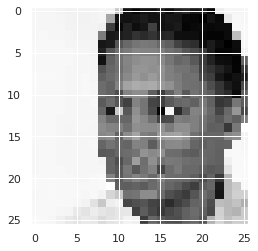

In [4]:
print(image_list.shape)
image_shape = image_list.shape[1:] # Grab the dimensions of each individual image for reshaping later
plt.imshow(image_list[0,:,:], cmap='gray')
plt.show()

In [5]:
image_flattened = image_list.reshape(num_images, -1) 
print(image_list.shape)

(100, 26, 26)


In [12]:
n_components = 100
pca = PCA(n_components=n_components, random_state=0)
pca.fit(image_flattened.T)


PCA(n_components=100, random_state=0)

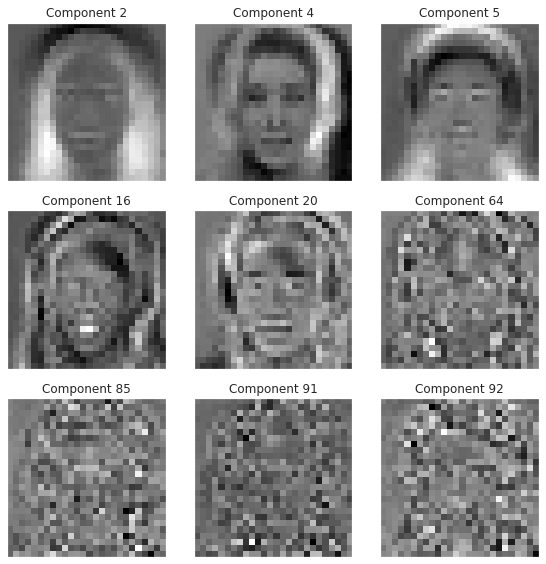

In [36]:
component_list = sorted(np.random.choice(range(n_components), size=9))

fig, axs = plt.subplots(3, 3, figsize=(8,8), tight_layout=True)
for ax, idx in zip(axs.reshape(-1), component_list):
    eigen_face = mixed_transformed[:,idx].reshape(image_shape)
    ax.imshow(eigen_face, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f'Component {idx}')
